<a href="https://colab.research.google.com/github/gsusAguirreArz/proyectoConexionistaA21/blob/master/Proyecto_Simpson_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Simpson -CNN
A continuación se listan las partes, si tiene un # a la derecha se ha comentado para evitar la demora de dichas tareas:
- Etapa 1: Cargado y preprocesado
  - Ejemplo
  - Preprocesado #
  - Carga de preprocesamientos
  - Entrada de los datos
- Etapa 2: Diseño de la red
  - Objeto CNN
  - Implementación 
  - Entrenamiento   #
  - Guardado de la red entrenada #
  - Cargado de los valores entrenados
  - Resumen del modelo cargado  
- Etapa 3: Implementado en Tensorboard
- Etapa 4: Desarrollo de visualización de pesos (propio)

## Resumen de la arquitectura
- Inicialización de la red: 
  - distribución normal centrada en 0 con varianza de 0.001
- Forma de la red: 
  - Convolucional 5x5, de 3 a 8
  - MaxPooling 2x2, stride de 2
  - Normalizado de salidas
  - Convolucional 3x3, de 8 a 16
  - MaxPooling 2x2, stride de 2
  - Normalizado de salidas
  - Flateen  a 4096 pesos
  - Completamente conectada a 256
  - Completamente conectada a número de personajes a usar
- Forma de la entrada:
  - Imagen de $64 * 64 * 3$ 
- Optimizador: 
  - Adam, Lr= 0.01, Epsilon = 1e-8
- BatchSize: 256
- Early Stopping al 99/90 de precisión (training/test)
- Personajes: 20


In [1]:
# Bloque de imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from PIL import Image,ImageOps #Libreria de imagenes
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle #porque sino vamos a meter en orden las cosas***
import tensorflow as tf


#Para tensorboard:
%load_ext tensorboard
import datetime



### Etapa 1: Cargado y preprocesado


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive/Colab Notebooks/CIC-RNA-avanzadas-Duchanoy/Proyecto CNN Simpson"


'Borrador proyecto Simpson - CNN'   CNN1_Modelo_3   logs
 CNN1_Modelo_1			    CNN1_Modelo_5  'Proyecto Simpson - CNN'
 CNN1_Modelo_2			    data


In [4]:
cd /content/drive/My Drive/Colab Notebooks/CIC-RNA-avanzadas-Duchanoy/Proyecto CNN Simpson

/content/drive/My Drive/Colab Notebooks/CIC-RNA-avanzadas-Duchanoy/Proyecto CNN Simpson


In [5]:
#paths declarados de utilidad
dir= !pwd
dirTrain   = dir[0] + '/data/simpsons_dataset'
dirTest    = dir[0] + '/data/simpsons_testdataset'
dirTrainP  = dir[0] + '/data/trainPrep'
dirTestP   = dir[0] + '/data/testPrep'


In [6]:
#Contenido del directorio general
os.listdir()

['Proyecto Simpson - CNN',
 'data',
 'CNN1_Modelo_1',
 'CNN1_Modelo_2',
 'Borrador proyecto Simpson - CNN',
 'CNN1_Modelo_3',
 'CNN1_Modelo_5',
 'logs']

In [7]:
#Listado de personajes
os.chdir(dirTest)
personajes=os.listdir()

In [8]:
os.chdir(dirTrain)
ejemploName = os.listdir()[-1]

In [9]:
os.chdir(dirTrain+'/'+ejemploName)
os.listdir()[:5]
#Nombres de los primeros 10 archivos, abriremos el primero

['27pic_0000.jpg',
 '27pic_0004.jpg',
 '27pic_0006.jpg',
 '27pic_0005.jpg',
 '27pic_0007.jpg']

In [10]:
imagenEjemplo = dirTrain+'/'+ejemploName+'/'+os.listdir()[0]

In [11]:
imagen = Image.open(imagenEjemplo)

#### Preprocesado

Se cargará imagen por imagen y se guardarán ya procesadas

##### Ejemplo del preprocesamiento

In [12]:
np.array(imagen).shape

(416, 288, 3)

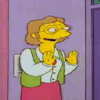

In [13]:
#resize a 100x100 pixeles
imagen = imagen.resize((100,100)) 
imagen 

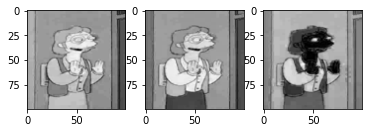

In [14]:
#Ilustración de las 3 capas a usar
imagen2 = np.array(imagen)
imagen2.shape
imagen2=imagen2.transpose( 2,0,1 )

fig1 = plt.figure(figsize=(6,10))
ax   = fig1.add_subplot(1,3,1)
ax.imshow(imagen2[0],cmap='gray')
ax   = fig1.add_subplot(1,3,2)
ax.imshow(imagen2[1],cmap='gray')
ax   = fig1.add_subplot(1,3,3)
ax.imshow(imagen2[2],cmap='gray')


##### Funciones para carga, preprocesado y guardado

In [15]:
#función para preprocesar datos:
def PreprocesarDatos(dirOrigen,dirDestino,numeroInicio,numeroFin,resize,personajes):
  for personaje in personajes[numeroInicio:numeroFin]:  
    os.chdir(dirDestino) 

    #Creamos carpeta con el nombre del personaje
    try:
      os.chdir( os.getcwd() +'/'+personaje)  
    except FileNotFoundError:
      os.mkdir( os.getcwd()+ '/'+personaje  )  

    #Nos movemos a la ubicación de imagenes del personaje
    print('personaje actual: ',personaje)
    os.chdir(dirOrigen+'/'+personaje)
    imagenes = os.listdir()
    
    #Acumuladores de datos procesados
    x_v=[]
    y_v=[]
    i=0
    for imagenName in imagenes:
      i=i+1
      if i%50 ==0:
        print(i)
      imagen  = Image.open(imagenName)
      imagen  = imagen.resize((resize,resize))  #Escalar

      imagen = np.array(imagen)
      imagen = imagen/255 #Normalizado

      #Retirado de imagenes que no tengan 3 capas:
      if(len(imagen.shape)==3):
        if(imagen.shape[2]==3): 
          x_v.append(imagen)
      
    y_v.append(personaje)
    y_v=y_v*len(x_v) #Número de veces que se debe repetir el target
    x_v=np.array(x_v)
    y_v=np.array(y_v)
    #Nos movemos para guardar todo el conjunto de imagenes y target del personaje
   
    #Esto se puede hacer con un with
    os.chdir(dirDestino+'/'+personaje+'/') 
    pickle.dump(x_v, open(personaje+"Data", 'wb'))
    pickle.dump(y_v, open(personaje+"Target", 'wb'))
    #Regresamos al directorio donde se encuentran el resto, mejorar con with
    os.chdir(dirOrigen+'/'+personaje+'/')     



In [16]:
#Tabla auxiliar para saber que elementos se han preprocesado

# 32x32
# de 0 a 3
# de 3 a 6
# de 6 a 10 

# 64x64
# de 0 a 3
# de 3 a 10
# de 10 a 20
# de 20 a 30
# de 30 a 40
# de 40 a 49

##### Aplicación de preprocesamiento

In [17]:
#PreprocesarDatos(dirTrain, dir[0]+'/data/trainPrep',40,49   ,64 ,personajes)        

In [18]:
#PreprocesarDatos(dirTest,dir[0]+'/data/testPrep',40,49,64,personajes)

#### Carga de datos preprocesados

In [19]:
#Número de personajes a usar
n = 10


##### Función de carga de datos

In [20]:
def CargadorDatos(dirOrigen, n,personajes):
  #Se elige directorio origen y número de personajes
  x_v =[]
  y_v =[]
  i = 0 #indice de personaje
  t = 0 #total de personajes agregados
  while t < n:
  
    personaje = personajes[i]
    os.chdir(dirOrigen+'/'+personaje)

    #cargar todo  con 64x64 

    #LOAD 
    data = pickle.load(open(personaje+'Data','rb')) 
    
    #If a implementar para regular que personajes pueden ser cargados
    # 0 -> todos serán considerados
    # 
    if(len(data)>0):    
      t=t+1
      x_v.extend( data )
      y_v.extend( pickle.load( open(personaje+'Target','rb'))  )
    i=i+1 
  return np.array(x_v) , np.array(y_v)

##### Carga de datos

In [21]:
x_train,y_train = CargadorDatos(dirTrainP,n,personajes)
x_test, y_test  = CargadorDatos(dirTestP ,n,personajes)

In [22]:
#Forma de los datos:
# Dato, H,W, capas
np.shape(x_test)

(682, 64, 64, 3)

#### Ejemplos de entrada de la red


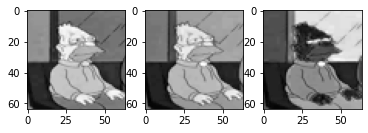

In [23]:
#Input
ex=x_train[0]

fig2 = plt.figure(figsize=(6,10))
ax   = fig2.add_subplot(1,3,1)
ax.imshow(ex[:,:,0],cmap='gray')
ax   = fig2.add_subplot(1,3,2)
ax.imshow(ex[:,:,1],cmap='gray')
ax   = fig2.add_subplot(1,3,3)
ax.imshow(ex[:,:,2],cmap='gray')



#### Sobre los tamaños de los conjuntos:

In [24]:
#Entrenamiento, Prueba
len(y_train),len(y_test)

(7343, 682)

In [25]:
#Re escalado de los tamaños para proporción 80/20
X = np.concatenate( (x_test,x_train), axis = 0)
y = np.concatenate( (y_test,y_train), axis = 0)
X.shape,y.shape

((8025, 64, 64, 3), (8025,))

In [26]:
#Re-escalado 70/30
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.30)

In [27]:
#Aplicando one-hot y creando diccionario de traducción del mismo:

onehot_encoder = OneHotEncoder(sparse=False)

y_train = y_train.reshape(len(y_train), 1)
y_train_onehot = onehot_encoder.fit_transform(y_train)


y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoder.fit_transform(y_test)

In [28]:
#ejemplo de un onehot
y_train_onehot[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

#### Shuffle para evitar aprender el orden de los datos

In [29]:
x_train, y_train, y_train_onehot = shuffle(x_train, y_train, y_train_onehot, random_state=None)
x_test,  y_test,  y_test_onehot  = shuffle(x_test,  y_test,  y_test_onehot,  random_state=None)

In [30]:
#Proporción de datos  

len(x_test)/ (  len(x_train)+len(x_test) )


0.3000623052959502

### Etapa 2: Diseño de red

- Optimizador, y métricas a usar
- Grafo computacional (train y test)
- Entrenamiento
- Implementado y pseudoevaluado
- Muestra de ejemplos clasificados 

#### Declarado de la arquitectura

In [31]:
class CNN_Model(object):
  def __init__(self, clases =10): 
    #Arquitectura tratará de usar el color... 
      # Capas convolucionales
        #Convolución con 16filtros

    amp=0.001 #amplitud del rand

    
    self.h1LW = tf.Variable(amp*np.random.randn(5,5,3,8),name="hl1weigths",dtype="float32")
    
    self.h1LB = tf.Variable(amp*np.random.randn(8),name="hl1bias",dtype="float32")
    
        #MAX pooling (no tiene pesos)

        #Convolución con 16 filtros
    self.h2LW = tf.Variable(amp*np.random.randn(3,3,8,16),name="hl2weigths",dtype="float32")
    self.h2LB = tf.Variable(amp*np.random.randn(16),name="hl2bias",dtype="float32")
    
        #MAX pooling (no tiene pesos)

        #Flatten final
    self.h3LW = tf.Variable(amp*np.random.randn(16*16*16,256),name="hl3weigths",dtype="float32")
    self.h3LB = tf.Variable(amp*np.random.randn(256),name="hl3bias",dtype="float32")
  
    

      #Capas completamente conectadas
        #Primera reducción
    self.outW = tf.Variable(amp*np.random.rand(256, clases),name="outweigths",dtype="float32")
    self.outB = tf.Variable(amp*np.random.rand(clases),name="outbias",dtype="float32")
    
    #Para el grafo computacional, variables a entrenar:
    self.trainable_variables =[self.h1LW,self.h1LB,                               
                               self.h2LW,self.h2LB,
                               self.h3LW,self.h3LB,
                               self.outW,self.outB]
    
    #Donde x representa la entrada de dato                        

    #No me gusta que se hinche a lo loco los valores, le meteré un normalizador entre capas
    #Layer normalization       
  def __call__(self,x,rate):
      x   = tf.cast(x, tf.float32) #Volvemos float32 porque TF explota sino (? aver)
      img = tf.reshape(x, shape=[-1, 64, 64, 3])  #Reshape con: batch, ancho, alto, colores 
      # 64*64*3

      l1 = tf.nn.conv2d(img, self.h1LW, strides=[1,1,1,1], padding='SAME' )  
      #Salto entre batches, [espacial, espacial], filtro/color  
      
      #Revisar espacial

      l1 = tf.add(l1, self.h1LB)
      l1 = tf.nn.relu(l1)
      l1 = tf.nn.max_pool(l1, ksize=2, strides=2, padding='SAME' )
      
      l1 = l1/tf.reduce_max(abs(l1))
      #l1 = (l1-tf.reduce_min(l1))/tf.reduce_max(l1)
              
      # 32 * 32 * 16
      
      l2 = tf.nn.conv2d(l1,self.h2LW, strides=[1,1,1,1], padding='SAME')  
      l2 = tf.add(l2, self.h2LB)
      l2 = tf.nn.relu(l2)
      l2 = tf.nn.max_pool(l2, ksize=2, strides=2, padding='SAME')
      
      l2 = l2/tf.reduce_max(abs(l2))
      #l2 = (l2-tf.reduce_min(l2))/tf.reduce_max(l2)
      
      #l2 = tf.nn.dropout(l2,rate)  
      # 16 * 16 * 16
      
      #Capas completamente conectadas
      l3 = tf.reshape(l2,[-1, 16*16*16])
      l3 = tf.add(tf.matmul(l3,self.h3LW),self.h3LB)
      l3 = tf.nn.relu(l3)
      
      l3 = l3/tf.reduce_max(abs(l3))
        
      #l3 = (l3-tf.reduce_min(l3))/tf.reduce_max(l3)
      l3 = tf.nn.dropout(l3,rate)    
   
      
      output = tf.add( tf.matmul(l3,self.outW) , self.outB)
      #output = output/tf.reduce_max(output)


      return output          

In [32]:
#Prueba de propagación hacía adelante, uso de n
CNN1 = CNN_Model(clases = n)
CNN1(x_train[0],0.0)
 

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.02005553, 0.01848817, 0.02055231, 0.0172898 , 0.019735  ,
        0.01849574, 0.01832829, 0.01927057, 0.01990086, 0.0179661 ]],
      dtype=float32)>

In [33]:
#Detalles de pesos:
for tensor in CNN1.trainable_variables:
  print(tensor.shape,   np.sum (  tensor.value()  )  , np.max(tensor.value()) , np.min(tensor.value() )) 



(5, 5, 3, 8) -0.011115694 0.004870084 -0.0026299688
(8,) 0.001243697 0.0014130132 -0.0010859804
(3, 3, 8, 16) 0.018991606 0.003209492 -0.0031415063
(16,) 0.0021024738 0.0016346847 -0.0032505915
(4096, 256) -1.6405864 0.0048204893 -0.0047686934
(256,) -0.008743391 0.0026185028 -0.002963513
(256, 10) 1.281877 0.0009995158 1.5555271e-06
(10,) 0.0062507084 0.0009347959 4.552912e-05


In [34]:
#Metricas a usar
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

##### Pasos de entrenamiento y de prueba

In [35]:
  ############## Declarado del optimizador
  optimizador = tf.compat.v1.train.AdamOptimizer( learning_rate=0.01,epsilon= 1e-8)
  ##############    

In [36]:
@tf.function
def TrainingStep(model, tdata, etiquetas,rate):
  

  with tf.GradientTape() as tape:

    prediction = model(tdata,rate)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(etiquetas,prediction))
  
  gradients = tape.gradient(loss, model.trainable_variables)  #Con que sacar gradiente
  capped_grad_and_vars = [(grad,model.trainable_variables[index]) for index,grad in enumerate(gradients)] #Elementos a modificar
  optimizador.apply_gradients(capped_grad_and_vars) #Modificar
  train_loss(loss)
  train_accuracy(etiquetas, prediction)


In [37]:
@tf.function
def TestStep(model,tdata, etiquetas):
  predictions = model(tdata,0)
  t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(etiquetas, predictions))
  
  test_loss(t_loss)
  test_accuracy(etiquetas, predictions)
  

##### Prepatativos para Tensorboard

In [38]:
#Subimos a directorio principal para guardado aquí de los logs
os.chdir(dir[0])

In [39]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/CIC-RNA-avanzadas-Duchanoy/Proyecto CNN Simpson'

In [40]:
rm -rf ./logs/

In [41]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#Directorios de guardado de la info:
train_log_dir = 'logs/gradient_tape/'  + current_time + '/train'
test_log_dir  = 'logs/gradient_tape/'  + current_time + '/test'
CL1_log_dir   = 'logs/gradient_tape/' + current_time + '/CL1'
CL2_log_dir   = 'logs/gradient_tape/'  + current_time + '/CL2'

#Escritores de la info:
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer  = tf.summary.create_file_writer(test_log_dir)
CL1_summary_writer   = tf.summary.create_file_writer(CL1_log_dir)
CL2_summary_writer   = tf.summary.create_file_writer(CL2_log_dir)

##### Función de ajuste

In [42]:
# Utilizo un tamaño de batch que varia para el último batch

def fitting(model,train_x,train_y,test_x,test_y,
            epochs,batchSize,
            rate):


  #Mientras el valor de la epoca actual sea menor que la cantidad total de datos:
  for epoch in range(epochs):
    i=0
    #Bucle del training step
      #agregando suffle, diferentes batches cada vez
    train_x,train_y = shuffle(train_x,train_y, random_state=None)

    while i<len(train_x):
      start = i

      if (i+batchSize)<len(train_x):
        end = i+batchSize  
      else:
        end = len(train_x)
      batch_x = train_x[start:end]
      batch_y = train_y[start:end]
      
      TrainingStep( model, batch_x, batch_y,rate)
      
      #Guardado
      with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

      i+=batchSize

    TestStep( model,test_x,test_y)

    #Guardado 
    with test_summary_writer.as_default():
      tf.summary.scalar('loss', test_loss.result(), step=epoch)
      tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
      

    #Presentación de resultados
    template = 'Epoch {0}, Perdida: {1:.3f}, Exactitud: {2:.3f}, Perdida de prueba: {3:.3f}, Exactitud de prueba: {4:.3f}'
    print(template.format(epoch+1,
                        train_loss.result().numpy(),
                        train_accuracy.result().numpy()*100,
                        test_loss.result().numpy(),
                        test_accuracy.result().numpy()*100    )   )
    
    #Early stopping
    if( train_accuracy.result().numpy()>0.99 and test_accuracy.result().numpy()>0.90 ):
      print('stop')
      break;
      
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    
    
      

#### Aplicación de la red

In [ ]:
#modelo, entradas, target, test_entrada, target_test, epocas, batchSize
fitting( CNN1,x_train,y_train_onehot, x_test,y_test_onehot,
        epochs= 25, batchSize = 32,
        rate = 0.15 )
# 10 personajes, tasa:"70/30, train/test" , dropout=0.1 , 25 epochs, lr= 0.01
# batchSize: 32, 0.6%~ , 156 batches aprox ::: 99/82

# 100 epochs, drop 0.0 --> 100/71 Overfitting
# 25 epochs, drop 0.2  --> 96/80
# 25 epochs, drop 0.3  --> 93/75 + 25epochs--> 98/78
# 25 epochs, drop 0.4  --> 89/71
# 25 epochs, drop 0.5  --> 

Epoch 1, Perdida: 1.731, Exactitud: 35.428, Perdida de prueba: 1.578, Exactitud de prueba: 42.442
Epoch 2, Perdida: 1.462, Exactitud: 47.018, Perdida de prueba: 1.364, Exactitud de prueba: 52.201
Epoch 3, Perdida: 1.267, Exactitud: 56.578, Perdida de prueba: 1.268, Exactitud de prueba: 56.769


In [ ]:
total = 255**3*64**2
param= 0
for tensor in CNN1.trainable_variables:
  param = param +np.size(tensor)
param/total 

In [ ]:
#Distribuciones de las entradas, nos indica el % que representan 
distribuciones=np.sum(y_test_onehot,axis=0)/np.sum(y_test_onehot)
distribuciones

In [ ]:
#Nos muestra cuantos de los primeros N personajes representan cierto porcentaje del total
distribuciones.sort()
np.cumsum(distribuciones[::-1])

Solo es necesario clasificar bien a 7 personajes para lograr el 95% de acc


#### Guardado de la red y carga de la misma


In [ ]:
os.chdir(dir[0]) #Subimos a directorio principal para guardar aquí el modelo
pickle.dump(CNN1, open('CNN1_Modelo_5', 'wb'))
  

In [ ]:
os.chdir(dir[0]) #Subimos a directorio principal para guardar aquí el modelo
CNN2 = pickle.load(open('CNN1_Modelo_5', 'rb'))

#### Ejemplo de evaluación

In [ ]:
personajes=onehot_encoder.categories_[0]

fig3 = plt.figure(figsize=(14,14))


#Nueve ejemplos 
for i in range(3):
  for j in range (3):
    value = np.random.randint(0,len(x_test))
    ejemplo = x_test[value]
    prediccion = np.argmax( CNN2(ejemplo,0.0)  )
    verdadero  = np.argmax(y_test_onehot[value])

    ax   = fig3.add_subplot(3,3,i*3+(j+1))
    ax.imshow(ejemplo)
    ax.axis('off')
    label='True:'+ str(personajes[verdadero])+'\n Predic:'+ str(personajes[prediccion]) 
    ax.set_title(label )
    
    


#### Resumen de modelo
Indicar número de caracteristicas por capa

In [ ]:
for capa in CNN1.trainable_variables:
  valorDeCapa= capa.numpy().size
  print('Capa tiene:',valorDeCapa )



### Etapa 4: Implementación de Tensorboard

In [ ]:
%tensorboard --logdir logs/gradient_tape


## Etapa 5: Visualización con historia
Aquí se intentará mostrar la evolución de los pesos de las capas convolucionales. \
Se deja como trabajo futuro, lo actualizaré si lo termino.


In [ ]:

#Leer los logs creados por tensorboard >:v
# -> Evolución de los pesos en capas convolucionales

#intentar implementar los propios
